## test log softmax on Movielens1M

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pdb
from heapq import heappush, heappop
from auxiliary import ScaledEmbedding, ZeroEmbedding
import evaluation
import data_loader
from tqdm import tqdm
import time
from cpt import PT_LogSoftmax
import sys
import json

params = dict()
params['lr'] = 1e-4
params['batch_size'] = 256
params['epoch_limit'] = 50
params['w_decay'] = 1e-1
params['negNum_test'] = 100
params['epsilon'] = 1e-4
params['negNum_train'] = 2
params['l_size'] = 16
params['train_device'] = 'cuda:2'
params['test_device'] = 'cuda:2'
params['test_per_train'] = 10

Precision@: {1:0.25231788079470197; 5: 0.09933774834437077; 10: 0.06115894039735356}
Recall@: {1:0.25231788079470197; 5: 0.4966887417218543; 10: 0.6115894039735099}
F1@: {1:0.25231788079470197; 5: 0.16556291390728464; 10: 0.11119807344973333}
NDCG@: {1:0.25231788079470197; 5: 0.4307096069509847; 10: 0.4701980019108464}
AUC:0.14624999999999716

In [2]:
params = dict()
params['lr'] = 1e-4
params['batch_size'] = 256
params['epoch_limit'] = 50
params['w_decay'] = 1e-1
params['negNum_test'] = 100
params['epsilon'] = 1e-4
params['negNum_train'] = 2
params['l_size'] = 16
params['train_device'] = 'cuda:2'
params['test_device'] = 'cuda:2'
params['test_per_train'] = 10

In [3]:
category = 'Movielens1M'

train, test = data_loader.read_data(category)
userNum, itemNum = data_loader.get_datasize(category)
frequency = data_loader.get_distribution(category)
distribution = data_loader.approx_Gaussian(frequency)
item_price = data_loader.get_price(category)

trainset = data_loader.TransactionData(train, userNum, itemNum, distribution)
trainset.set_negN(params['negNum_train'])
trainLoader = DataLoader(trainset, batch_size=params['batch_size'], shuffle=False, num_workers=0)

testset = data_loader.UserTransactionData(test, userNum, itemNum, trainset.userHist)
testset.set_negN(params['negNum_test'])
testLoader = DataLoader(testset, batch_size=1, shuffle=False, num_workers=0)

In [4]:
class PT(nn.Module):
    def __init__(self, userLen, itemLen, distribution, params, item_price):
        super(PT, self).__init__()
        self.userNum = userLen
        self.itemNum = itemLen
        self.params = params

        if 'gpu' in params and params['gpu'] == True:
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        l_size = params['l_size']
        self.distribution = torch.FloatTensor(distribution).to(self.device)
        self.item_price = torch.FloatTensor(item_price).to(self.device)
        
        self.globalBias_g = ZeroEmbedding(1, 1).to(self.device).to(torch.float)
        self.globalBias_g.weight.data += 0.5
        self.globalBias_g.weight.requires_grad = False
        self.userBias_g = ZeroEmbedding(userLen, 1).to(self.device).to(torch.float)
        self.itemBias_g = ZeroEmbedding(itemLen, 1).to(self.device).to(torch.float)
        self.userEmbed_g = ScaledEmbedding(userLen, l_size).to(self.device).to(torch.float)
        self.itemEmbed_g = ScaledEmbedding(itemLen, l_size).to(self.device).to(torch.float)

        self.globalBias_d = ZeroEmbedding(1, 1).to(self.device).to(torch.float)
        self.globalBias_d.weight.data += 0.5
        self.globalBias_d.weight.requires_grad = False
        self.userBias_d = ZeroEmbedding(userLen, 1).to(self.device).to(torch.float)
        self.itemBias_d = ZeroEmbedding(itemLen, 1).to(self.device).to(torch.float)
        self.userEmbed_d = ScaledEmbedding(userLen, l_size).to(self.device).to(torch.float)
        self.itemEmbed_d = ScaledEmbedding(itemLen, l_size).to(self.device).to(torch.float)

        self.globalBias_a = ZeroEmbedding(1, 1).to(self.device).to(torch.float)
        self.globalBias_a.weight.requires_grad = False
        self.userBias_a = ZeroEmbedding(userLen, 1).to(self.device).to(torch.float)
        self.userBias_a.weight.data.uniform_(0.0, 0.05)
        self.itemBias_a = ZeroEmbedding(itemLen, 1).to(self.device).to(torch.float)
        self.itemBias_a.weight.data.uniform_(0.0, 0.05)
        self.userEmbed_a = ZeroEmbedding(userLen, l_size).to(self.device).to(torch.float)
        self.userEmbed_a.weight.data.uniform_(-0.01, 0.01)
        self.itemEmbed_a = ZeroEmbedding(itemLen, l_size).to(self.device).to(torch.float)
        self.itemEmbed_a.weight.data.uniform_(-0.01, 0.01)

        self.globalBias_b = ZeroEmbedding(1, 1).to(self.device).to(torch.float)
        self.globalBias_b.weight.requires_grad = False
        self.userBias_b = ZeroEmbedding(userLen, 1).to(self.device).to(torch.float)
        self.userBias_b.weight.data.uniform_(0.0, 0.05)
        self.itemBias_b = ZeroEmbedding(itemLen, 1).to(self.device).to(torch.float)
        self.itemBias_b.weight.data.uniform_(0.0, 0.05)
        self.userEmbed_b = ZeroEmbedding(userLen, l_size).to(self.device).to(torch.float)
        self.userEmbed_b.weight.data.uniform_(-0.01, 0.01)
        self.itemEmbed_b = ZeroEmbedding(itemLen, l_size).to(self.device).to(torch.float)
        self.itemEmbed_b.weight.data.uniform_(-0.01, 0.01)

        self.globalBias_l = ZeroEmbedding(1, 1).to(self.device).to(torch.float)
        self.globalBias_l.weight.requires_grad = False
        self.userBias_l = ZeroEmbedding(userLen, 1).to(self.device).to(torch.float)
        self.userBias_l.weight.data.uniform_(0.0, 0.05)
        self.itemBias_l = ZeroEmbedding(itemLen, 1).to(self.device).to(torch.float)
        self.itemBias_l.weight.data.uniform_(0.0, 0.05)
        self.userEmbed_l = ZeroEmbedding(userLen, l_size).to(self.device).to(torch.float)
        self.userEmbed_l.weight.data.uniform_(-0.01, 0.01)
        self.itemEmbed_l = ZeroEmbedding(itemLen, l_size).to(self.device).to(torch.float)
        self.itemEmbed_l.weight.data.uniform_(-0.01, 0.01)
        
        self.reference_point = ZeroEmbedding(userLen, 1).to(self.device).to(torch.float)
        self.reference_point.weight.data = torch.ones_like(self.reference_point.weight.data)*1.5
#         self.reference_point.weight.requires_grad=False
        self.to(self.device)  
        self.grads = {}
        
    def forward(self, users, items):
        distribution = self.distribution[items].to(self.device)
        reference_point = self.reference_point(users)
        price = self.item_price[items].view(-1,1).expand(users.shape[0],5).to(self.device)

        # calculate value
        globalBias_a = self.globalBias_a(torch.tensor(0).to(self.device))
        userBias_a = self.userBias_a(users)
        itemBias_a = self.itemBias_a(items)
        userEmbed_a = self.userEmbed_a(users)
        itemEmbed_a = self.itemEmbed_a(items)

        globalBias_b = self.globalBias_b(torch.tensor(0).to(self.device))
        userBias_b = self.userBias_b(users)
        itemBias_b = self.itemBias_b(items)
        userEmbed_b = self.userEmbed_b(users)
        itemEmbed_b = self.itemEmbed_b(items)
        
        globalBias_l = self.globalBias_l(torch.tensor(0).to(self.device))
        userBias_l = self.userBias_l(users)
        itemBias_l = self.itemBias_l(items)
        userEmbed_l = self.userEmbed_l(users)
        itemEmbed_l = self.itemEmbed_l(items)

        alpha = globalBias_a + userBias_a + itemBias_a + torch.mul(userEmbed_a, itemEmbed_a).sum(1).view(-1, 1)
        beta = globalBias_b + userBias_b + itemBias_b + torch.mul(userEmbed_b, itemEmbed_b).sum(1).view(-1, 1)
        lamda = globalBias_l + userBias_l + itemBias_l + torch.mul(userEmbed_l, itemEmbed_l).sum(1).view(-1, 1)

        rating = torch.tensor([1., 2., 3., 4., 5.]).expand(users.shape[0], 5).to(self.device)
        x = torch.tanh(rating - reference_point)
        x_binary_pos = torch.gt(x, torch.FloatTensor([0]).to(self.device)).to(torch.float)
        x_binary_neg = torch.ones_like(x).to(self.device) - x_binary_pos
        
#         x_ = torch.mul(price,torch.abs(x))
        x_ = torch.abs(x)
        v_exp = torch.mul(alpha, x_binary_pos) + torch.mul(beta, x_binary_neg)
        v = x_.pow(v_exp)
        v_coef = torch.mul(lamda, x_binary_pos) - x_binary_neg
        value = torch.mul(v,v_coef).to(self.device)        


        # calculate weight
        globalBias_g = self.globalBias_g(torch.tensor(0).to(self.device))
        userBias_g = self.userBias_g(users)
        itemBias_g = self.itemBias_g(items)
        userEmbed_g = self.userEmbed_g(users)
        itemEmbed_g = self.itemEmbed_g(items)

        globalBias_d = self.globalBias_d(torch.tensor(0).to(self.device))
        userBias_d = self.userBias_d(users)
        itemBias_d = self.itemBias_d(items)
        userEmbed_d = self.userEmbed_d(users)
        itemEmbed_d = self.itemEmbed_d(items)

        gamma = globalBias_g + userBias_g + itemBias_g + torch.mul(userEmbed_g, itemEmbed_g).sum(1).view(-1, 1)
        delta = globalBias_d + userBias_d + itemBias_d + torch.mul(userEmbed_d, itemEmbed_d).sum(1).view(-1, 1)

        gamma_ = gamma.expand(users.shape[0],5)
        delta_ = delta.expand(users.shape[0],5)
        w_exp = torch.mul(x_binary_pos,gamma_) + torch.mul(x_binary_neg,delta_)
        
        w_nominator = distribution.pow(w_exp)
        w_denominator = (distribution.pow(w_exp)+(torch.ones_like(distribution).to(self.device)-distribution).pow(w_exp)).pow(1/w_exp)
        weight = torch.div(w_nominator, w_denominator)
        

#         self.userBias_g.weight.register_hook(self.save_grad('userBias_g'))
#         self.itemBias_g.weight.register_hook(self.save_grad('itemBias_g'))
#         self.userEmbed_g.weight.register_hook(self.save_grad('userEmbed_g'))
#         self.itemEmbed_g.weight.register_hook(self.save_grad('itemEmbed_g'))
        return torch.mul(weight, value).sum(1)

    def loss(self, users, items, negItems):
        nusers = users.view(-1, 1).to(self.device)
        nusers = nusers.expand(nusers.shape[0], self.params['negNum_train']).reshape(-1).to(self.device)

        pOut = self.forward(users, items).view(-1, 1)#.expand(users.shape[0], self.params['negNum_train']).reshape(-1, 1)
        nOut = self.forward(nusers, negItems).reshape(-1, self.params['negNum_train'])
        Out = torch.cat((pOut,nOut),dim=1)
        
#         print(Out.shape)
#         print(nOut.shape)
#         input()
        criterion = nn.LogSoftmax(dim=1)
        res = criterion(Out)[:,0]
        loss = torch.mean(res)
        return -loss

    def get_grads(self):
        return self.grads

    def save_grad(self, name):
        def hook(grad):
            self.grads[name] = grad
        return hook

In [5]:
model = PT_LogSoftmax(userLen=userNum, itemLen=itemNum, distribution=distribution, params=params, item_price=item_price)
# print('initialization', model.state_dict())
# optimizer = optim.SGD(model.parameters(), lr=params['lr'], weight_decay=params['w_decay'])
optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['w_decay'])

epoch = 0
print('start training...')
while epoch < params['epoch_limit']:
    model.device = params['train_device']
    model.to(model.device)

    epoch += 1
    print('Epoch ', str(epoch), ' training...')
    L = len(trainLoader.dataset)
    pbar = tqdm(total = L, file=sys.stdout)
    pbar.set_description('processed: %d' % epoch)
    for i, batchData in enumerate(trainLoader):
        optimizer.zero_grad()
        users = torch.LongTensor(batchData['user']).to(model.device)
        items = torch.LongTensor(batchData['item']).to(model.device)
        negItems = torch.LongTensor(batchData['negItem']).reshape(-1).to(model.device)

        batch_loss = model.loss(users, items, negItems)
        batch_loss.backward()
        grads = model.get_grads()
        
#         print('userBias_g:',grads['userBias_g'])
#         print('itemBias_g:',grads['itemBias_g'])
#         print('userEmbed_g:',grads['userEmbed_g'])
#         print('itemEmbed_g:',grads['itemEmbed_g'])
#         input()

        
        optimizer.step()
        optimizer.zero_grad()
        if i == 0:
            total_loss = batch_loss.clone()
        else:
            total_loss += batch_loss.clone()
        pbar.update(users.shape[0])
    pbar.close()
    # torch.save(model, 'pt.pt')
    print('epoch loss', total_loss)
#     print(model.state_dict())

    if epoch % params['test_per_train'] == 0:
        print('starting val...')
        model.device = params['test_device']
        model.to(model.device)
        L = len(testLoader.dataset)
        pbar = tqdm(total=L, file=sys.stdout)
        with torch.no_grad():
            scoreDict = dict()
            for i, batchData in enumerate(testLoader):
#                 if np.random.random() < 0.98:
#                     pbar.update(1)
#                     continue
#                 if i%50 != 0:
#                     pbar.update(1)
#                     continue
                user = torch.LongTensor(batchData['user']).to(model.device)
                posItems = torch.LongTensor(batchData['posItem']).to(model.device)
                negItems = torch.LongTensor(batchData['negItem']).to(model.device)

                items = torch.cat((posItems, negItems), 1).view(-1)
                users = user.expand(items.shape[0])

                score = model.forward(users, items)
                scoreHeap = list()
                for j in range(score.shape[0]):
                    gt = False
                    if j < posItems.shape[1]:
                        gt = True

                    heappush(scoreHeap, (1-score[j].cpu().numpy(), (0+items[j].cpu().numpy(), gt)))
                scores = list()
                candidate = len(scoreHeap)
                for k in range(candidate):
                    scores.append(heappop(scoreHeap))
                pbar.update(1)
                scoreDict[user[0]] = (scores, posItems.shape[1])
        pbar.close()
        testResult = evaluation.ranking_performance(scoreDict, 100)
#         with open('./results/'+category+'/'+category+'_PT_valResult_'+str(epoch)+'.json', 'w') as outfile:
#             json.dump(testResult, outfile)
        
print('starting test...')
model.device = params['test_device']
model.to(model.device)
L = len(testLoader.dataset)
pbar = tqdm(total=L, file=sys.stdout)
alpha = []
beta = []
lamda = []
gamma = []
delta = []
ref = []
with torch.no_grad():
    scoreDict = dict()
    for i, batchData in enumerate(testLoader):
        user = torch.LongTensor(batchData['user']).to(model.device)
        posItems = torch.LongTensor(batchData['posItem']).to(model.device)
        negItems = torch.LongTensor(batchData['negItem']).to(model.device)

        items = torch.cat((posItems, negItems), 1).view(-1)
        users = user.expand(items.shape[0])
        
        [a,b,l,g,d,r] = model.get_paras(users,items)
    
        
        alpha.append(a.cpu().numpy())
        beta.append(b.cpu().numpy())
        lamda.append(l.cpu().numpy())
        gamma.append(g.cpu().numpy())
        delta.append(d.cpu().numpy())
        ref.append(r.cpu().numpy())
        
        score = model.forward(users, items)
        scoreHeap = list()
        for j in range(score.shape[0]):
            gt = False
            if j < posItems.shape[1]:
                gt = True

            heappush(scoreHeap, (1-score[j].cpu().numpy(), (0+items[j].cpu().numpy(), gt)))
        scores = list()
        candidate = len(scoreHeap)
        for k in range(candidate):
            scores.append(heappop(scoreHeap))
        pbar.update(1)
        scoreDict[int(user[0].cpu().numpy())] = (scores, posItems.shape[1])
pbar.close()
testResult = evaluation.ranking_performance(scoreDict, 100)

start training...
Epoch  1  training...
processed: 1: 100%|██████████| 988129/988129 [02:24<00:00, 6822.19it/s]
epoch loss tensor(4120.8696, device='cuda:2', grad_fn=<AddBackward0>)
Epoch  2  training...
processed: 2: 100%|██████████| 988129/988129 [02:22<00:00, 6923.42it/s]
epoch loss tensor(4190.0693, device='cuda:2', grad_fn=<AddBackward0>)
Epoch  3  training...
processed: 3: 100%|██████████| 988129/988129 [02:24<00:00, 6829.31it/s]
epoch loss tensor(4227.5044, device='cuda:2', grad_fn=<AddBackward0>)
Epoch  4  training...
processed: 4: 100%|██████████| 988129/988129 [02:28<00:00, 6673.82it/s]
epoch loss tensor(4227.5112, device='cuda:2', grad_fn=<AddBackward0>)
Epoch  5  training...
processed: 5: 100%|██████████| 988129/988129 [02:28<00:00, 6660.85it/s]
epoch loss tensor(4227.5078, device='cuda:2', grad_fn=<AddBackward0>)
Epoch  6  training...
processed: 6: 100%|██████████| 988129/988129 [02:29<00:00, 6631.52it/s]
epoch loss tensor(4227.4956, device='cuda:2', grad_fn=<AddBackward0>

In [8]:
with open('./results/'+category+'/'+category+'_PT_testResult.json', 'w') as outfile:
    json.dump(testResult, outfile)

In [9]:
a_ = np.array([float(j) for i in alpha for j in i])
b_ = np.array([float(j) for i in beta for j in i])
g_ = np.array([float(j) for i in gamma for j in i])
d_ = np.array([float(j) for i in delta for j in i])
l_ = np.array([float(j) for i in lamda for j in i])
r_ = np.array([float(j) for i in ref for j in i])

np.save('./results/'+category+'/'+category+'_PT_alpha.npy',a_)
np.save('./results/'+category+'/'+category+'_PT_beta.npy',b_)
np.save('./results/'+category+'/'+category+'_PT_gamma.npy',g_)
np.save('./results/'+category+'/'+category+'_PT_delta.npy',d_)
np.save('./results/'+category+'/'+category+'_PT_lamda.npy',l_)
np.save('./results/'+category+'/'+category+'_PT_reference.npy',r_)

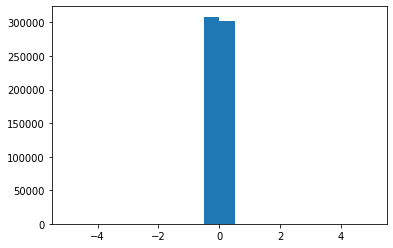

In [11]:
import numpy as np
import matplotlib.pyplot as plt

result = plt.hist(r_,bins=20,range=(-5,5))
plt.show()